# Notebook to show results

Import libraries and helper functions needed

In [62]:
import pandas as pd
import math

from modules.graph_functions import (plot_3d_graph_models,
                                     plot_3d_graph_slice,
                                     plot_heatmap,
                                     )

from modules.helper_results import (read_data, 
                                    filter_results_general,
                                    filter_results_qml,
                                    filter_results_ml,
                                    find_quality,
                                    select_key_fields_qml,
                                    select_key_fields_ml,
                                    )

SHOW_COUNTS = False # Show how much many relevant datapoints have been read?  If False, the quality, or error will be shown instead.


## Analysis of slicing

In [63]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode,monte_carlo,layers,elapsed
169,10,1.0,2.0,290.2,290.2,1.000000,0.000000,2.0,False,NaN,144.811068
179,10,1.0,73.0,290.2,290.2,1.000000,0.000000,2.0,False,NaN,150.290042
192,10,1.0,116.0,290.2,290.2,1.000000,0.000000,2.0,False,NaN,151.025354
204,10,1.0,12.0,290.3,290.2,0.999656,0.000344,2.0,False,NaN,133.189836
671,9,1.0,181.0,286.7,286.7,1.000000,0.000000,2.0,False,NaN,63.587238


In [64]:
if SHOW_COUNTS:
    slice_count = df.groupby(['locations', 'slice']).count()
    slice_count.head()
    slice_count_pivot = slice_count.pivot_table(index='locations', columns='slice', values='quality')
    print(slice_count_pivot)

In [65]:
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000232,0.000232
3,9,0.4,0.003285,0.003033
4,9,0.5,0.008944,0.008944


In [66]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000232,0.000232
3,9,0.4,0.003285,0.003033
4,9,0.5,0.008944,0.008944


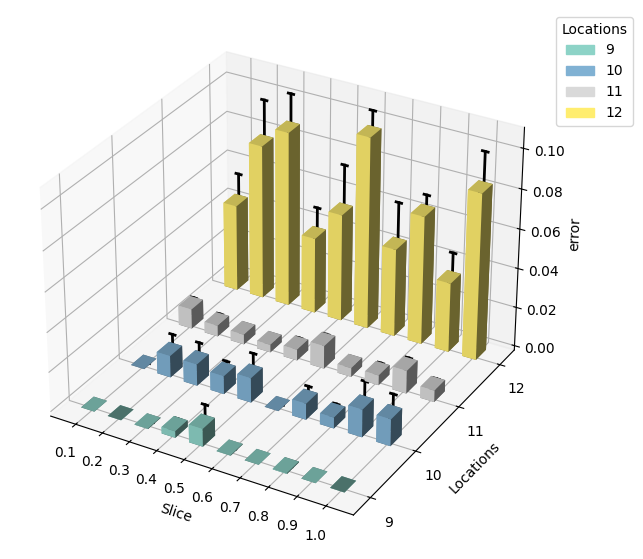

In [67]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

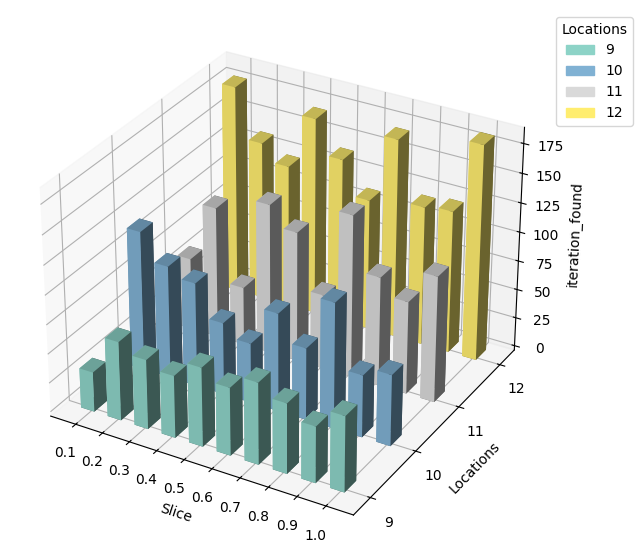

In [68]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()

input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of different VQA models

In [69]:
qml_mode = read_data()
qml_mode = filter_results_qml(qml_mode)
qml_mode = find_quality(qml_mode, factor=100, round=1)
#qml_mode = qml_mode[(qml_mode['mode'] == 2)]
#qml_mode = qml_mode[(qml_mode['locations'] == 12)]
qml_mode = qml_mode[(qml_mode['slice'] == 0.8)]
qml_mode = qml_mode[['locations', 'slice','iteration_found', 
                     'best_dist_found', 'best_dist', 
                     'quality', 'error','mode',
                     'cache_misses', 'cache_hits']]
qml_mode_pivot = qml_mode.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc=['mean', 'sem', 'count']
)
qml_mode_pivot = qml_mode_pivot.round(1)
print(qml_mode_pivot)

            mean                              sem                     count  \
mode         1.0    2.0    3.0    4.0    6.0  1.0  2.0  3.0  4.0  6.0   1.0   
locations                                                                     
4          100.0  100.0  100.0  100.0  100.0  0.0  0.0  0.0  0.0  0.0    10   
5          100.0  100.0  100.0  100.0  100.0  0.0  0.0  0.0  0.0  0.0    10   
6          100.0  100.0   98.3   99.7  100.0  0.0  0.0  1.4  0.3  0.0    10   
7          100.0  100.0   99.7   97.8  100.0  0.0  0.0  0.3  1.5  0.0    10   
8          100.0  100.0   99.6   96.8  100.0  0.0  0.0  0.3  1.6  0.0    10   
9           99.0  100.0   97.9   92.7   98.8  0.8  0.0  1.2  1.8  0.9    10   
10          98.4   99.5   96.0   92.7   98.7  0.8  0.4  1.6  2.1  0.5    10   
11          98.9   99.5   97.6   96.0   99.7  0.2  0.3  1.0  1.0  0.1     7   
12          95.4   93.5   92.9   88.3   90.5  1.2  0.8  1.6  2.5  1.9     7   

                           
mode      2.0 3.0 4.0 6

In [70]:
qml_mode_summary = qml_mode.mean(axis=0).reset_index()

In [71]:
#calculate overall mean for each mode
qml_mode_summary = qml_mode_pivot.mean(axis=0).reset_index()
qml_mode_summary = qml_mode_summary.round(1)
print(qml_mode_summary)

   level_0  mode     0
0     mean   1.0  99.1
1     mean   2.0  99.2
2     mean   3.0  98.0
3     mean   4.0  96.0
4     mean   6.0  98.6
5      sem   1.0   0.3
6      sem   2.0   0.2
7      sem   3.0   0.8
8      sem   4.0   1.2
9      sem   6.0   0.4
10   count   1.0   9.3
11   count   2.0  12.3
12   count   3.0   9.3
13   count   4.0   9.3
14   count   6.0   9.3


### Evaluate cache hits

In [72]:
qml_mode['total_cache_calls'] = qml_mode['cache_misses'] + qml_mode['cache_hits']
qml_mode['permutations'] = qml_mode['locations'].apply(lambda x: 0.5 * math.factorial(x - 1))
qml_mode['cover'] = qml_mode['total_cache_calls'] / qml_mode['permutations']


In [73]:
#pivot table for cache hits
qml_mode_pivot_cache = qml_mode.pivot_table(       
        index='locations', 
        columns='mode', 
        values=['cover','permutations', 'total_cache_calls'],
        aggfunc=['mean']
        )

print(qml_mode_pivot_cache)

                  mean                                                      \
                 cover                                                       
mode               1.0          2.0          3.0          4.0          6.0   
locations                                                                    
4          2596.833333  2650.566667  2386.933333  2187.200000  2544.033333   
5          1271.516667  1638.441667   900.933333   757.516667  1410.708333   
6          1107.051667  1569.191667   451.990000   428.086667  1202.193333   
7           683.074444   520.887222   211.499444   114.322222   520.693889   
8           173.122381   217.876389    57.789087    34.527500   175.136548   
9            27.711687    33.805833    12.785818     4.575094    22.919340   
10            4.249982     4.927173     2.056634     1.657515     4.592962   
11            0.526499     0.527591     0.276339     0.158806     0.512024   
12            0.050272     0.050663     0.032621     0.032532   

## Analysis of ml models with different numbers of layers

In [74]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [75]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()

c:\Users\DanielGoldsmith\python_notebooks\TSP_VQC\modules\graph_functions.py:238: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


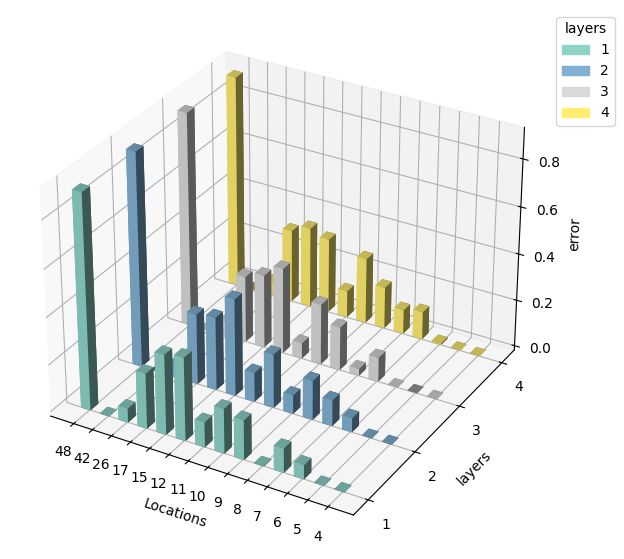

In [76]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [77]:
df['quality'] = df['quality']*100
ml_layer_pivot = df.pivot_table(
        index='locations', 
        columns='layers', 
        values='quality',
        aggfunc= ['mean', 'sem', 'count']
        )
ml_layer_pivot = ml_layer_pivot.round(1)
print(ml_layer_pivot)


            mean                       sem           count         
layers         1      2      3      4    1    2    4     1  2  3  4
locations                                                          
4          100.0  100.0  100.0  100.0  NaN  NaN  0.0     1  1  1  6
5          100.0  100.0  100.0  100.0  NaN  NaN  0.0     1  1  1  6
6           94.0   94.0  100.0   99.5  NaN  NaN  0.5     1  1  1  6
7           89.7   89.0   89.7   88.2  NaN  NaN  1.0     1  1  1  6
8           99.8   83.3   97.1   89.7  NaN  NaN  5.2     1  1  1  6
9           83.3   92.1   81.5   82.1  NaN  NaN  2.3     1  1  1  6
10          81.1   77.1   74.1   72.0  4.3  4.5  2.2     3  6  1  6
11          89.4   87.5   93.4   88.5  NaN  NaN  0.5     1  1  1  6
12          64.8   58.8   63.5   68.1  NaN  NaN  4.4     1  1  1  6
15          66.1   69.0   68.8   65.6  NaN  NaN  2.7     1  1  1  6
17          76.6   70.0   71.7   68.9  NaN  NaN  2.6     1  1  1  6
26          94.1   94.1   94.1   94.1  0.0  NaN 

In [78]:
ml_layer_summary = ml_layer_pivot.mean(axis=0).reset_index()
ml_layer_summary = ml_layer_summary.round(1)
ml_layer_summary.head()

,level_0,layers,0
0,mean,1,82.0
1,mean,2,80.3
2,mean,3,81.6
3,mean,4,80.4
4,sem,1,1.4


# Impact of hot start

### VQA - hot start

In [79]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]


df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [80]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [81]:
hot_qml_pivot = hot_qml_mean.pivot_table(
    index='locations', 
    columns='hot_start', 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
hot_qml_pivot = hot_qml_pivot.round(1)
print(hot_qml_pivot)

            mean        count      
hot_start  False  True  False True 
locations                          
4          100.0  100.0     1     1
5          100.0  100.0     1     1
6          100.0  100.0     1     1
7          100.0  100.0     1     1
8          100.0  100.0     1     1
9          100.0  100.0     1     1
10          99.4   98.9     1     1
11          99.5  100.0     1     1
12          93.5   93.3     1     1


In [82]:
hot_qml_summary = hot_qml_pivot.mean(axis=0).reset_index()
hot_qml_summary.head()

,level_0,hot_start,0
0,mean,False,99.155556
1,mean,True,99.133333
2,count,False,1.000000
3,count,True,1.000000


### Classical ML - hot start

In [83]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [84]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [85]:
hot_ml_pivot = hot_ml_mean.pivot_table(
    index='locations', 
    columns='hot_start', 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
hot_ml_pivot = hot_ml_pivot.round(1)
print(hot_ml_pivot)

            mean        count      
hot_start  False  True  False True 
locations                          
4          100.0  100.0     1     1
5          100.0  100.0     1     1
6           98.3   88.7     1     1
7           88.6  100.0     1     1
8           90.9   94.6     1     1
9           83.3  100.0     1     1
10          75.8   90.5     1     1
11          89.1   93.0     1     1
12          66.2   78.8     1     1
15          66.4   70.4     1     1
17          70.2   70.7     1     1
26          94.1   78.0     1     1
42         100.0   77.7     1     1
48           9.3    9.4     1     1


In [86]:
hot_ml_summary = hot_ml_pivot.mean(axis=0).reset_index()
hot_ml_summary.head()

,level_0,hot_start,0
0,mean,False,80.871429
1,mean,True,82.271429
2,count,False,1.000000
3,count,True,1.000000


## Impact of Gray encoding

###VQA - Gray

In [87]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
if SHOW_COUNTS:
    gray_mean_qml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', 
                                           columns='gray', 
                                           values='quality', 
                                           aggfunc= ['mean', 'sem', 'count'])
gray_qml_pivot = gray_qml_pivot.round(1)
print(gray_qml_pivot)


            mean        count      
gray       False  True  False True 
locations                          
4          100.0  100.0     1     1
5          100.0  100.0     1     1
6          100.0  100.0     1     1
7          100.0  100.0     1     1
8          100.0  100.0     1     1
9          100.0   99.4     1     1
10          99.4   98.5     1     1
11          99.5   98.8     1     1
12          93.5   96.7     1     1


In [88]:

gray_summary_qml = gray_qml_pivot.mean(axis=0).reset_index()
gray_summary_qml.head(20)

,level_0,gray,0
0,mean,False,99.155556
1,mean,True,99.266667
2,count,False,1.000000
3,count,True,1.000000


### Classical ML - Gray

In [89]:

df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    gray_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

In [90]:
gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(1)
print(gray_ml_pivot)

gray       False  True 
locations              
4          100.0  100.0
5          100.0   98.1
6           99.5  100.0
7           88.2   98.9
8           89.7   80.6
9           82.1   78.4
10          72.0   72.0
11          88.5   89.3
12          68.1   70.4
15          65.6   67.1
17          68.9   71.9
26          94.1   93.5
42         100.0  100.0
48           9.4    9.6


In [91]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,43.661905,8598.32500,1185.821429,80.441208,19.558792,8.0
1,True,15.714286,1.0,46.493651,8446.50397,1185.821429,80.700148,19.299852,8.0


## Impact of formalation

### QML - formulation

In [92]:
df = read_data()
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'formulation',]]

form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
if SHOW_COUNTS:
    form_mean_qml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
form_qml_pivot = form_mean_qml.pivot_table(index='locations', columns='formulation', values='quality')
form_qml_pivot = form_qml_pivot.round(1)
form_qml_pivot = form_qml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_qml_pivot)


formulation  factorial  non-factorial
locations                            
4                100.0          100.0
5                100.0          100.0
6                100.0          100.0
7                100.0          100.0
8                100.0          100.0
9                100.0          100.0
10                99.1           99.4
11                99.2           99.5
12                91.4           93.5


In [93]:
form_summary_qml = form_qml_pivot.mean(axis=0).reset_index()
form_summary_qml.head()

,formulation,0
0,factorial,98.855556
1,non-factorial,99.155556


## Classical ML formulation

In [94]:
df = read_data()
df = df[(df['gray'] == False)]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] < 26)]  #issue calculating large locations

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'formulation', ]]

if SHOW_COUNTS:
    form_mean_ml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_ml = df.groupby(['locations', 'formulation',]).mean().reset_index()

form_ml_pivot = form_mean_ml.pivot_table(index='locations', columns='formulation', values='quality')
form_ml_pivot = form_ml_pivot.round(1)
form_ml_pivot = form_ml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_ml_pivot)

formulation  factorial  non-factorial
locations                            
4                100.0          100.0
5                100.0          100.0
6                 99.3           99.5
7                 95.5           88.2
8                 81.9           89.7
9                 85.0           82.1
10                76.9           72.0
11                87.4           88.5
12                68.8           68.1
15                69.9           65.6
17                72.6           68.9


In [95]:
form_summary_ml = form_ml_pivot.mean(axis=0).reset_index()
form_summary_ml.head()

,formulation,0
0,factorial,85.209091
1,non-factorial,83.872727


## Impact of changing minibatch size for ML

In [96]:
SHOW_COUNTS = False
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]
df = df[(df['shots'] != 2)]
df = df[(df['layers'] == 4)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['gradient_type'] == 'SGD')]

df = find_quality(df, factor=100,)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'cache_misses', 'cache_hits']]

df["shots"] = df["shots"].round().astype(int)

shots_ml_pivot = df.pivot_table(index='locations', 
                                           columns='shots', 
                                           values='quality',
                                           aggfunc=['mean', 'sem', 'count',]
                                         )



shots_ml_pivot = shots_ml_pivot.round(1)

print(shots_ml_pivot)

            mean                                                          sem  \
shots       4      8      16     32     64     128    256    512    1024 64     
locations                                                                       
4          100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  0.0   
5          100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  0.0   
6           94.0   94.0   94.0  100.0   99.3  100.0  100.0  100.0  100.0  0.7   
7           89.7   89.7   87.7   89.0   87.9   89.0  100.0  100.0  100.0  1.2   
8           83.5   82.7   83.3  100.0   93.9  100.0  100.0  100.0  100.0  3.8   
9           83.3   74.0   81.4   92.1   81.8  100.0   99.0  100.0  100.0  2.8   
10          72.9   61.1   73.3   73.7   71.9   88.3   96.6  100.0   97.5  2.7   
11          87.5   87.5   90.7   87.5   88.2   87.5   91.9   98.8   98.7  0.4   
12          65.8   58.8   63.3   70.0   70.4   78.7   84.4   83.5   90.7  4.5   
15          70.8   73.9   65

c:\Users\DanielGoldsmith\python_notebooks\TSP_VQC\modules\graph_functions.py:238: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


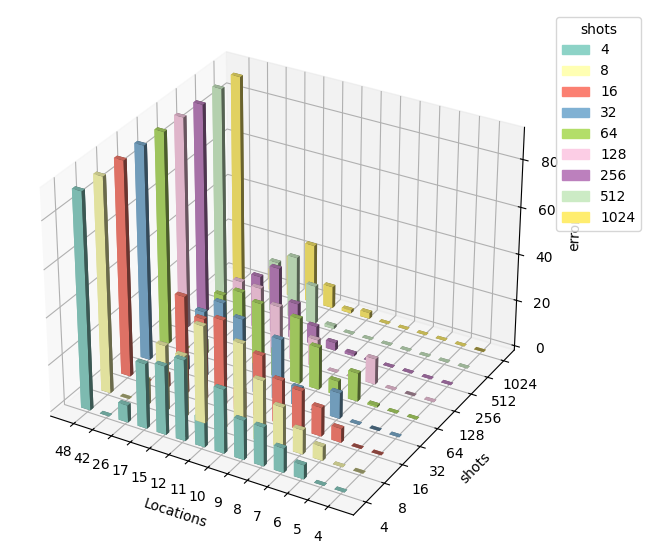

(None,)

In [97]:
shots_mean_ml = df.groupby(['locations', 'shots',]).mean().reset_index()
plot_3d_graph_models(shots_mean_ml, 
                     input = 'error', 
                     input2='shots'), 

*** Impact of shots on solutions found, iterations and average execution time.

In [98]:
shots_mean2_ml = df.groupby(['shots',]).mean().reset_index()
shots_mean2_ml = shots_mean2_ml.round(1)
print(shots_mean2_ml)

   shots  locations  iteration_found  quality  error  elapsed  cache_misses  \
0      4       15.7             79.3     80.1   19.9     42.1       17725.8   
1      8       15.7             49.1     78.0   22.0     84.2       33608.5   
2     16       15.7             41.2     78.6   21.4    166.1       65659.6   
3     32       15.7             32.2     82.3   17.7    331.8      154629.1   
4     64       15.7             37.1     81.2   18.8    621.9      313094.8   
5    128       15.7             41.2     85.0   15.0   1346.2      949681.2   
6    256       15.7             49.4     87.2   12.8   2854.9     2877155.6   
7    512       15.7             58.8     88.1   11.9   8090.0     5875187.2   
8   1024       13.1             72.3     92.3    7.7  10082.8     7837699.8   

   cache_hits  
0     34840.8  
1     71524.6  
2    144606.7  
3    265903.4  
4    527970.4  
5    732449.1  
6    487104.9  
7    853333.9  
8   2233444.7  


###  Cache hits


In [99]:
df = df[(df['shots'] == 1024)]
df['total_cache_calls'] = df['cache_misses'] + df['cache_hits']
df['permutations'] = df['locations' ].apply(lambda x: 0.5* math.factorial(x - 1))

df['coverage'] = df['total_cache_calls'] / df['permutations']
df.head()


cache_ml_pivot = df.pivot_table(index='locations', 
                                           columns='shots', 
                                           values=['total_cache_calls', 'permutations', 'coverage'],
                                           aggfunc=['mean', ]
                                         )

cache_ml_pivot = cache_ml_pivot.map(lambda x: format(x, ".3e"))                                  

print(cache_ml_pivot)

                mean                               
            coverage permutations total_cache_calls
shots           1024         1024              1024
locations                                          
4          3.427e+05    3.000e+00         1.028e+06
5          1.285e+05    1.200e+01         1.542e+06
6          3.855e+04    6.000e+01         2.313e+06
7          8.567e+03    3.600e+02         3.084e+06
8          1.530e+03    2.520e+03         3.855e+06
9          2.295e+02    2.016e+04         4.626e+06
10         3.116e+01    1.814e+05         5.655e+06
11         3.683e+00    1.814e+06         6.683e+06
12         3.863e-01    1.996e+07         7.711e+06
15         2.477e-04    4.359e+10         1.080e+07
17         1.228e-06    1.046e+13         1.285e+07
26         3.148e-18    7.756e+24         2.442e+07
42         2.827e-42    1.673e+49         4.729e+07
48         4.373e-52    1.293e+59         5.655e+07


In [100]:


shots_summary_ml = df.groupby(['shots',]).mean().reset_index()
shots_summary_ml.drop(columns=['locations'], inplace=True)
shots_summary_ml.drop(columns=['error'], inplace=True)
shots_summary_ml['elapsed'] = shots_summary_ml['elapsed'].astype(int)
shots_summary_ml['iteration_found'] = shots_summary_ml['iteration_found'].round(1)
shots_summary_ml['quality'] = shots_summary_ml['quality'].round(1)
print(shots_summary_ml.to_string(index=False))

 shots  iteration_found  quality  elapsed  cache_misses   cache_hits  total_cache_calls  permutations     coverage
  1024             72.3     92.3    10082  7.837700e+06 2.233445e+06       1.007114e+07  5.278025e+57 31847.347166


## Impact of optimiser on Classical ML

In [101]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['gradient_type'] == 'SGD')]

df = find_quality(df, factor=100)

df_SGD = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

In [102]:
df_SGD.head()

,locations,iteration_found,quality,error,shots,elapsed,lr,weight_decay,gradient_type
1153,4,0.0,100.000000,0.000000,64.0,36.547650,0.00002,0.0006,SGD
1154,5,0.0,100.000000,0.000000,64.0,58.559934,0.00002,0.0006,SGD
1155,6,10.0,100.000000,0.000000,64.0,79.682216,0.00002,0.0006,SGD
1156,7,2.0,89.010638,10.989362,64.0,107.120503,0.00002,0.0006,SGD
1157,8,6.0,82.672237,17.327763,64.0,135.360423,0.00002,0.0006,SGD


In [103]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 0.001)]
df = df[(df['weight_decay'] == 0.0032)]
df = df[(df['gradient_type'] == 'Adam')]

df = find_quality(df, factor=100)

df_Adam = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

df_Adam.head()

,locations,iteration_found,quality,error,shots,elapsed,lr,weight_decay,gradient_type
2006,12,75.0,87.488958,12.511042,64.0,329.927990,0.001,0.0032,Adam
2055,4,0.0,100.000000,0.000000,64.0,57.947199,0.001,0.0032,Adam
2056,5,0.0,100.000000,0.000000,64.0,87.869632,0.001,0.0032,Adam
2057,6,12.0,100.000000,0.000000,64.0,109.506645,0.001,0.0032,Adam
2058,7,26.0,89.675325,10.324675,64.0,146.107287,0.001,0.0032,Adam


In [104]:
df_combined = pd.concat([df_SGD, df_Adam], ignore_index=True)
df_combined['quality'] = df_combined['quality'].round(1)

In [105]:
if SHOW_COUNTS:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).count().reset_index()
else:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).mean().reset_index()

In [106]:
optimiser_mean_ml = optimiser_mean_ml.round(1)
optimiser_mean_ml.head()

,locations,lr,gradient_type,shots,iteration_found,quality,error,elapsed,weight_decay
0,4,0.0,SGD,64.0,0.0,100.0,0.0,33.7,0.0
1,4,0.0,SGD,256.0,0.0,100.0,0.0,132.5,0.0
2,4,0.0,Adam,64.0,0.0,100.0,0.0,39.5,0.0
3,4,0.0,Adam,256.0,0.0,100.0,0.0,125.8,0.0
4,5,0.0,SGD,64.0,0.4,100.0,0.0,50.9,0.0


In [107]:
optimiser_ml_pivot = optimiser_mean_ml.pivot_table(
    index='locations', 
    columns=['gradient_type', 'shots'], 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
optimiser_ml_pivot = optimiser_ml_pivot.round(1)
print(optimiser_ml_pivot)

                mean                      count                  
gradient_type   Adam           SGD         Adam         SGD      
shots          64.0   256.0  64.0   256.0 64.0  256.0 64.0  256.0
locations                                                        
4              100.0  100.0  100.0  100.0     1     1     1     1
5              100.0  100.0  100.0  100.0     1     1     1     1
6              100.0  100.0   97.8  100.0     1     1     1     1
7               90.5   96.6   90.4  100.0     1     1     1     1
8               93.3   99.9   94.2  100.0     1     1     1     1
9               85.2   92.1   86.6   99.4     1     1     1     1
10              88.7   92.8   77.4   94.6     1     1     1     1
11              91.8   92.9   90.5   94.5     1     1     1     1
12              77.7   77.1   75.6   84.8     1     1     1     1
15              74.4   73.4   69.0   70.8     1     1     1     1
17              59.9   62.1   71.8   76.0     1     1     1     1
26        

In [108]:
optimiser_ml_summary_pivot = optimiser_mean_ml.pivot_table(
    index='gradient_type', 
    columns=['shots'], 
    values='quality',
    aggfunc='mean'  # or 'first', 'max', etc.
    )
optimiser_ml_summary_pivot = optimiser_ml_summary_pivot.round(1)
print(optimiser_ml_summary_pivot)

shots          64.0   256.0
gradient_type              
Adam            83.4   85.3
SGD             82.6   87.2


In [109]:

optimiser_summary_ml = optimiser_mean_ml.pivot_table(index='gradient_type', values='quality')
optimiser_summary_ml.head()

,quality
gradient_type,
Adam,84.353571
SGD,84.860714


### Adam hyperparameter training

In [110]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] == 12)]
df =df[df['gradient_type'] == 'Adam']
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', ]]

In [111]:
if SHOW_COUNTS:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
adam_mean_ml.head()

,lr,weight_decay,locations,iteration_found,quality,error,shots,elapsed,momentum
0,0.00002,0.0000,12.0,79.0,62.859562,37.140438,64.0,312.416320,NaN
1,0.00002,0.0001,12.0,191.0,59.321357,40.678643,64.0,296.820996,NaN
2,0.00002,0.0002,12.0,184.0,58.240252,41.759748,64.0,307.659295,NaN
3,0.00002,0.0004,12.0,223.0,60.345178,39.654822,64.0,283.444793,NaN
4,0.00002,0.0006,12.0,39.0,56.480424,43.519576,64.0,270.237657,0.8


c:\Users\DanielGoldsmith\python_notebooks\TSP_VQC\modules\graph_functions.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  x_labels = input.columns.format()


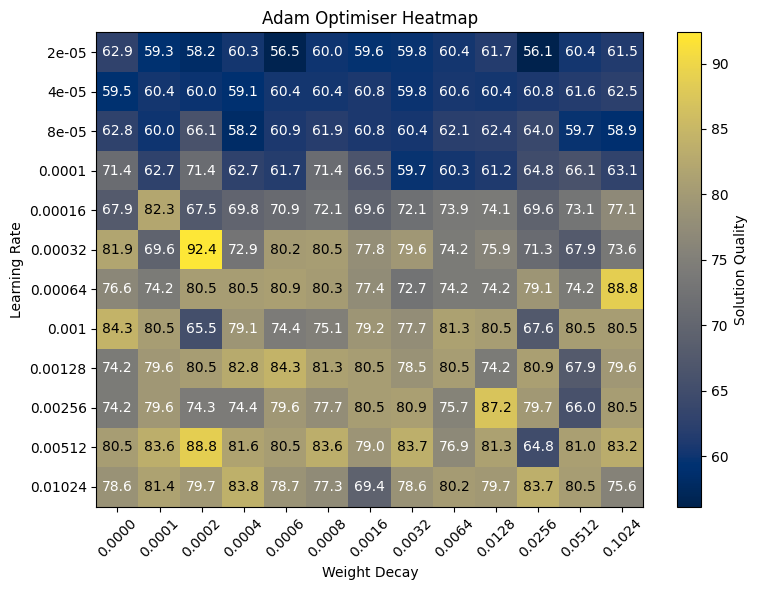

In [112]:
adam_summary_ml = adam_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(adam_summary_ml, 
             'Adam Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )


## SGD hyper parameter training

In [113]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 2)]
df = df[(df['locations'] == 10)]
df =df[df['gradient_type'] == 'SGD']
df =df[df['mode'] == 8]
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', 'layers']]

In [114]:
df = df[(df['momentum'] == 0.8)]
if SHOW_COUNTS:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
SGD_mean_ml.head()

,lr,weight_decay,locations,iteration_found,quality,error,shots,elapsed,momentum,layers
0,0.00001,0.0010,10.0,5.0,72.859656,27.140344,64.0,205.237614,0.8,2.0
1,0.00001,0.0020,10.0,21.0,77.759912,22.240088,64.0,201.277888,0.8,2.0
2,0.00001,0.0040,10.0,17.0,81.038815,18.961185,64.0,196.044414,0.8,2.0
3,0.00001,0.0080,10.0,181.0,88.287189,11.712811,64.0,193.797152,0.8,2.0
4,0.00002,0.0005,10.0,22.0,89.547559,10.452441,64.0,207.884731,0.8,2.0


c:\Users\DanielGoldsmith\python_notebooks\TSP_VQC\modules\graph_functions.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  x_labels = input.columns.format()


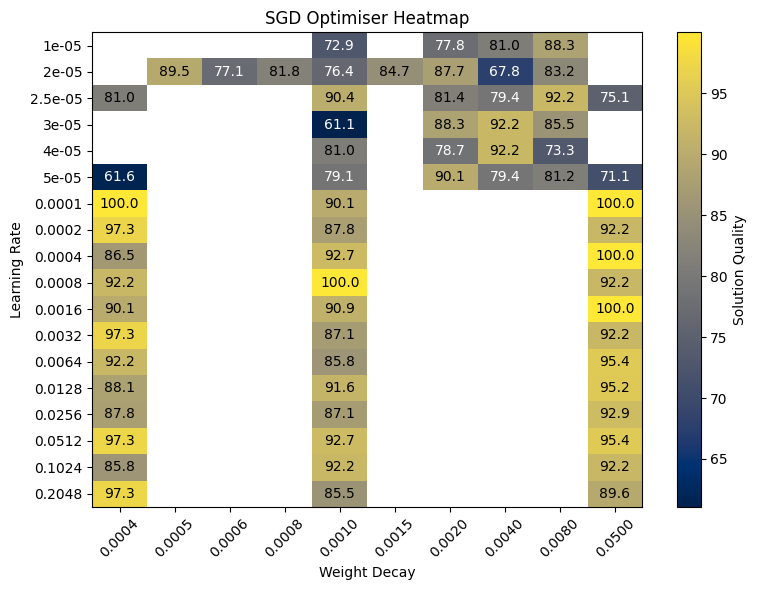

In [115]:
SGD_summary_ml = SGD_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(SGD_summary_ml, 
             'SGD Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )

## ML initialisation with different values

In [116]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['gradient_type'] == 'SGD')]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64
)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    mode_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    mode_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

mode_mean_ml.head()

,locations,gray,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,4,False,1.0,0.0,21.000000,21.0,100.000000,0.000000,8.5
1,5,False,1.0,0.4,19.000000,19.0,100.000000,0.000000,8.5
2,6,False,1.0,3.1,246.759999,241.0,97.834441,2.165559,8.5
3,7,False,1.0,15.7,306.229996,276.2,90.463143,9.536857,8.5
4,8,False,1.0,27.8,296.090005,277.2,94.200093,5.799907,8.5


In [117]:
mode_ml_pivot = df.pivot_table(
    index='locations', 
    columns=['mode'], 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
mode_ml_pivot = mode_ml_pivot.round(1)
print(mode_ml_pivot)

            mean         sem      count    
mode         8.0    9.0  8.0  9.0   8.0 9.0
locations                                  
4          100.0  100.0  0.0  0.0     5   5
5          100.0  100.0  0.0  0.0     5   5
6           99.3   96.3  0.7  2.5     5   5
7           87.9   93.1  1.2  2.8     5   5
8           93.9   94.5  3.8  3.5     5   5
9           81.8   91.5  2.8  2.9     5   5
10          71.9   83.0  2.7  3.0     5   5
11          88.2   92.8  0.4  0.3     5   5
12          70.4   80.9  4.5  0.7     5   5
15          67.9   70.0  1.7  0.8     5   5
17          71.5   72.1  0.6  1.8     5   5
26          94.1   92.5  0.0  0.7     5   5
42         100.0  100.0  0.0  0.0     5   5
48           9.4    9.2  0.1  0.0     5   5


In [118]:
mode_summary_ml_pivot = mode_ml_pivot.mean(axis=0).reset_index()
mode_summary_ml_pivot = mode_summary_ml_pivot.round(1)
mode_summary_ml_pivot.head(10)



,level_0,mode,0
0,mean,8.0,81.2
1,mean,9.0,84.0
2,sem,8.0,1.3
3,sem,9.0,1.4
4,count,8.0,5.0
5,count,9.0,5.0


## Noise

In [119]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]
df = df[(df['shots'] == 1024)]
df = df[(df['mode'] == 2)]

df['noise'] = df['noise'].fillna(False)
pd.set_option('future.no_silent_downcasting', True)
df = df[(df['noise'] == True)]

df = find_quality(df, factor=100)

In [120]:
noise_qml_pivot = df.pivot_table(
    index='locations', 
    columns = ['noise', 'iterations',],
    values= ['quality', 'elapsed',],
    aggfunc= ['mean', ],
    )
noise_qml_pivot = noise_qml_pivot.round(1)
print(noise_qml_pivot)

               mean        
            elapsed quality
noise          True    True
iterations    250.0   250.0
locations                  
4            1224.4   100.0
5            1130.4   100.0
6            2243.7   100.0
7            3823.3   100.0
8            7237.0   100.0
9           34989.7   100.0


## Iterations required

In [121]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]
df = df[(df['shots'] == 1024)]
df = df[(df['mode'] == 2)]


df = find_quality(df, factor=100)

In [122]:
iterations_qml_pivot = df.pivot_table(
    index = 'locations',
    columns = [],
    values= ['quality','iteration_found' ],
    aggfunc= ['mean', ],
    )
iterations_qml_pivot = iterations_qml_pivot.round(1)
print(iterations_qml_pivot)

                     mean        
          iteration_found quality
locations                        
4                     0.0   100.0
5                     0.4   100.0
6                     2.8   100.0
7                     1.4   100.0
8                     5.3   100.0
9                    53.6   100.0
10                  124.6    99.3
11                  109.6    99.6
12                  123.0    93.5
